In [1]:
from utils import process_tweet, lookup
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd


nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Importation de fonctions et de données

In [2]:
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)
print(stopwords.words("english")[:10])

# Vérifier si "not" est dans la liste des stopwords
if "not" in stopwords.words("english"):
    print("Le mot 'not' est présent dans la liste des stopwords en anglais.")
else:
    print("Le mot 'not' n'est pas présent dans la liste des stopwords en anglais.")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Le mot 'not' est présent dans la liste des stopwords en anglais.


In [3]:

all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')


test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg


train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
import string
from nltk.util import ngrams

def handle_negations(tweet):
    negation_words = set(['not', 'no', 'never', 'none', 'neither', 'nor'])

    for i in range(len(tweet)):
        if tweet[i] in negation_words and i + 1 < len(tweet):
            # Prefix the next word with "not_" to indicate negation
            tweet[i + 1] = 'not_' + tweet[i + 1]

    return tweet

def process_tweet(tweet,use_ngrams=True):
    stemmer = PorterStemmer()
    # Exclure spécifiquement le mot "not" de la liste des stopwords
    stopwords_english = set(stopwords.words('english')) - {'not'}

    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    if use_ngrams:
        tweet_tokens += [' '.join(gram) for gram in list(ngrams(tweet_tokens, 2))]

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and
                word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    # Ajouter l'appel à handle_negations ici
    tweets_clean = handle_negations(tweets_clean)

    return tweets_clean

tweet = 'i am not happy'
print(process_tweet(tweet))


['not', 'not_happi', 'i am', 'am not', 'not happi']


Traiter les données

Pour tout projet d'apprentissage machine, une fois que vous avez des données, la première est la première est l'entrée en cas de traitement en des entrées utiles pour votre modèle.

    Supprimer le bruit : Vous voudrez d'abord éliminer le bruit de vos données, c'est-à-dire supprimer les mots qui n'apportent pas un d'informations sur le contenu. Cela inclut tous tous les mots courants que 'I, you, are, is, etc...' qui neait fournir pas suffisamment d'informations sur le sentiment.
    Nous renouez les symboles des actions en bourse, les symboles de retweet, les liens hypertexte et les hashtags car ils ne ne pas fournir beaucoup d'informations sur le sentiment.
    Vous voudrez aussi supprimer toute la ponctuation d'un tweet. La raison de faire est ce qui nous traiter les mots avec ou sans ponctuation comme le mot, au lieu de traité « heureux », « heureux » ?, « heureux », « heureux », « heureux », et « heureux »., comme des mots différents.
    Enfin, vous voudrez utiliser le dents pour ne conserver qu'une variante de mot. En d'autres, nos traitéons "motivation", "motivated" et "motivate" de façon en les avons en pensions dans la main même "motiv-".

Nous vous avez la fonction  process_tweetqui fait cela pour vous.

In [5]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"


print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn', 'hello ther', 'there !', '! have', 'have a', 'a great', 'great day', 'day .', '. :)', ':) good', 'good morn']


Pour m'aider à former mon modèle de Bayes naïf, je devrai calculer un dictionnaire où les clés sont un tuple (mot, étiquette) et les valeurs sont la fréquence correspondante. Note que les étiquettes que j'utiliserai ici sont 1 pour positif et 0 pour négatif.

Je mettrai également en œuvre une fonction d'aide à la recherche qui s'inscrira dans le dictionnaire « freqs », un mot et une étiquette (1 ou 0), et retournera le nombre de fois où le mot et le tuple de l'étiquette apparaissent dans la collection de tweets.

Par exemple, avec une liste de tweets ["je suis plutôt excité", "je suis plutôt heureux"] et l'étiquette 1, la fonction retournera un dictionnaire qui contient les paires clé-valeur suivantes :

    ("plutôt", 1): 2,
    ("heureux", 1): 1,
    ("excité", 1): 1

In [7]:
from nltk.util import ngrams
def count_tweets(result, tweets, ys,use_ngrams=True):
   
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet,use_ngrams=False):

            pair = (word, y)
            
           
            if pair in result:
                result[pair] += 1

            
            else:
                result[pair] = 1

    return result


Entraîner notre modèle à l'aide de Naive Bayes

Naive Bayes est un algorithme qui peut être utilisé pour l'analyse de sentiment. Il faut peu de temps pour l'entraînement et a également un temps de prédiction court.

Comment entraîner un classificateur Naive Bayes ?

    La première étape de l'entraînement d'un classificateur Naive Bayes consiste à identifier le nombre de classes que vous avez.
    Vous allez créer une probabilité pour chaque classe.

    P(D_{pos}) est la probabilité que le document soit positif.
    P(D_{neg}) est la probabilité que le document soit négatif.
    Utilisez les formules suivantes et stockez les valeurs dans un dictionnaire :

P(D_{pos}) = D_{pos}\D

P(D_{neg}) = D_{neg}\D

Où D est le nombre total de documents, ou de tweets dans ce cas, D_{pos} est le nombre total de tweets positifs et D_{neg} est le nombre total de tweets négatifs.

Probabilité a priori et Logprobabilité a priori

La probabilité a priori représente la probabilité sous-jacente dans la population cible qu'un tweet soit positif par rapport à négatif. En d'autres termes, si nous n'avions aucune information spécifique et choisissions aveuglément un tweet dans l'ensemble de la population, quelle est la probabilité qu'il soit positif par rapport à négatif ? C'est le "a priori".

Le a priori est le rapport des probabilités P(Dpos)/P(Dneg).
Nous pouvons prendre le logarithme du a priori pour le remettre à l'échelle, et nous l'appellerons le logprior

logprior=log(P(Dneg​)\P(Dpos​)​)=log(Dneg\​Dpos​​).

Notez que log(A\B​) est le même que log⁡(A)−log⁡(B). Ainsi, le logprior peut également être calculé comme la différence entre deux logarithmes :

logprior=log(P(Dpos​))−log(P(Dneg​))=log(Dpos​)−log(Dneg​)

Probabilité positive et négative d'un mot

Pour calculer la probabilité positive et négative d'un mot spécifique dans le vocabulaire, nous utiliserons les fréquences suivantes :

    freqposfreqpos​ et freqnegfreqneg​ sont les fréquences de ce mot spécifique dans la classe positive ou négative. En d'autres termes, la fréquence positive d'un mot est le nombre de fois où le mot est compté avec l'étiquette 1.
    NposNpos​ et NnegNneg​ sont le nombre total de mots positifs et négatifs pour tous les documents (pour tous les tweets), respectivement.
    V est le nombre de mots uniques dans l'ensemble complet de documents, pour toutes les classes, qu'elles soient positives ou négatives.

    Nous utiliserons ces éléments pour calculer la probabilité positive et négative pour un mot spécifique en utilisant la formule suivante :

    𝑃(𝑊𝑝𝑜𝑠)=𝑓𝑟𝑒𝑞𝑝𝑜𝑠+1\𝑁𝑝𝑜𝑠+𝑉
    𝑃(𝑊𝑛𝑒𝑔)=𝑓𝑟𝑒𝑞𝑛𝑒𝑔+1\𝑁𝑛𝑒𝑔+𝑉
 

Log-vraisemblance

Pour calculer la log-vraisemblance de ce même mot, nous pouvons mettre en œuvre les équations suivantes :
loglikelihood = log P(W_{pos})\P(W_{neg})

In [8]:


result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [9]:

freqs = count_tweets({}, train_x, train_y)

In [10]:
def handle_negations(tweet):
    negation_words = set(['not', 'no', 'never', 'none', 'neither', 'nor'])

    for i in range(len(tweet)):
        if tweet[i] in negation_words and i + 1 < len(tweet):
            # Prefix the next word with "not_" to indicate negation
            tweet[i + 1] = 'not_' + tweet[i + 1]

    return tweet

In [11]:

def train_naive_bayes(freqs, train_x, train_y,use_ngrams=False):
    
    loglikelihood = {}
    logprior = 0
    

  
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)    

    
    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]
    
    
    D = len(train_y)

    
    D_pos = np.sum(train_y)

    
    D_neg = D - D_pos

    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    
    for word in vocab:
        if use_ngrams:
            ngram_tokens = word.split()
            freq_pos = freqs.get((ngram_tokens, 1), 0)
            freq_neg = freqs.get((ngram_tokens, 0), 0)
        else:
            freq_pos = freqs.get((word, 1), 0)
            freq_neg = freqs.get((word, 0), 0)
        p_w_pos = (freq_pos + 1) / (N_pos + V)  
        p_w_neg = (freq_neg + 1) / (N_neg + V)  

        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood


In [12]:

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9391


𝑝=𝑙𝑜𝑔𝑝𝑟𝑖𝑜𝑟+∑𝑖𝑁(𝑙𝑜𝑔𝑙𝑖𝑘𝑒𝑙𝑖ℎ𝑜𝑜𝑑𝑖)

In [13]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
   
    
    word_l = process_tweet(tweet)

    
    p = 0

    
    p += logprior

    for word in word_l:
        
        if word in loglikelihood:
            
            p += loglikelihood[word]

    return p


In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
import string
from nltk.util import ngrams

def handle_negations(tweet):
    negation_words = set(['not', 'no', 'never', 'none', 'neither', 'nor'])

    for i in range(len(tweet)):
        if tweet[i] in negation_words and i + 1 < len(tweet):
            # Prefix the next word with "not_" to indicate negation
            tweet[i + 1] = 'not_' + tweet[i + 1]

    return tweet

def process_tweet(tweet,use_ngrams=True):
    stemmer = PorterStemmer()
    # Exclure spécifiquement le mot "not" de la liste des stopwords
    stopwords_english = set(stopwords.words('english')) - {'not'}

    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    if use_ngrams:
        tweet_tokens += [' '.join(gram) for gram in list(ngrams(tweet_tokens, 2))]

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and
                word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    # Ajouter l'appel à handle_negations ici
    tweets_clean = handle_negations(tweets_clean)

    return tweets_clean

tweet = 'i am not happy'
print(process_tweet(tweet))


['not', 'not_happi', 'i am', 'am not', 'not happi']


In [15]:
tweet = 'i am not happy'
result = process_tweet(tweet)
print(result)

my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

['not', 'not_happi', 'i am', 'am not', 'not happi']
The expected output is 1.5611658326592506


In [16]:

my_tweet = 'He laughed.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is -0.16160076508185292


In [17]:


def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    
    accuracy = 0

    
    y_hats = []
    for tweet in test_x:
        
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
           
            y_hat_i = 1
        else:
           
            y_hat_i = 0

       
        y_hats.append(y_hat_i)

    
    error = np.mean(np.abs(y_hats - test_y))

   
    accuracy = 1 - error

    

    return accuracy


In [18]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))


Naive Bayes accuracy = 0.9950


Naive Bayes accuracy = 0.9950


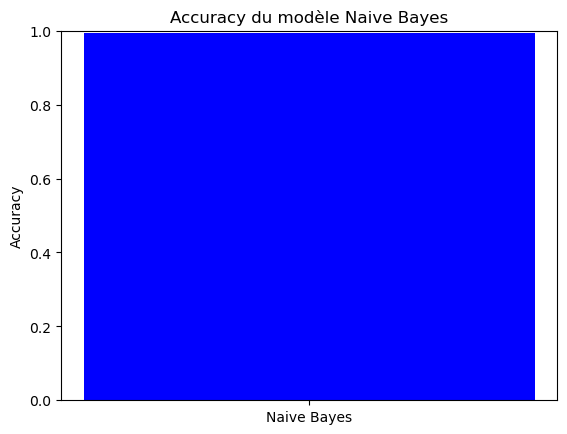

In [19]:
import matplotlib.pyplot as plt

# Supposons que test_naive_bayes renvoie l'accuracy directement
accuracy = test_naive_bayes(test_x, test_y, logprior, loglikelihood)

# Affichage de l'accuracy
print("Naive Bayes accuracy = %0.4f" % accuracy)

# Visualisation de l'accuracy
plt.bar(['Naive Bayes'], [accuracy], color=['blue'])
plt.ylim(0, 1)  # Assurez-vous que l'axe y est compris entre 0 et 1 pour représenter l'accuracy
plt.title('Accuracy du modèle Naive Bayes')
plt.ylabel('Accuracy')
plt.show()


In [20]:

for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
   
    p = naive_bayes_predict(tweet, logprior, loglikelihood)

    print(f'{tweet} -> {p:.2f}')

I am happy -> 2.14
I am bad -> -1.80
this movie should have been great. -> 2.25
great -> 2.26
great great -> 4.52
great great great -> 6.78
great great great great -> 9.04


In [21]:

my_tweet = 'you are bad :('
naive_bayes_predict(my_tweet, logprior, loglikelihood)

-9.316816485972582

Certains mots ont plus de occurrences positives que d'autres et peuvent être considérés comme "plus positifs". De même, certains mots peuvent être considérés comme plus négatifs que d'autres.
Une façon pour nous de définir le niveau de positivité ou de négativité, sans calculer la log-vraisemblance, consiste à comparer la fréquence positive à la fréquence négative du mot.
    Notez que nous pouvons également utiliser les calculs de log-vraisemblance pour comparer la positivité ou la négativité relative des mots.
Nous pouvons calculer le rapport des fréquences positives aux fréquences négatives d'un mot.
Une fois que nous sommes capables de calculer ces ratios, nous pouvons également filtrer un sous-ensemble de mots ayant un rapport minimum de positivité / négativité ou plus.
De même, nous pouvons également filtrer un sous-ensemble de mots ayant un rapport maximum de positivité / négativité ou moins (des mots qui sont au moins aussi négatifs, voire plus négatifs, qu'un seuil donné).

𝑟𝑎𝑡𝑖𝑜=pos_words+1\neg_words+1

In [22]:

def get_ratio(freqs, word):
    
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    
    
    pos_words = lookup(freqs, word, 1)
    
    
    neg_words = lookup(freqs, word, 0)
    
    
    pos_neg_ratio['ratio'] = (pos_words + 1) / (neg_words + 1)
    pos_neg_ratio['positive'] = pos_words
    pos_neg_ratio['negative'] = neg_words
   
    
    return pos_neg_ratio


In [23]:
get_ratio(freqs, 'happi')

{'positive': 161, 'negative': 18, 'ratio': 8.526315789473685}

In [24]:


def get_words_by_threshold(freqs, label, threshold, get_ratio=get_ratio):
    
    word_list = {}

    
    for word, _ in freqs.keys():
        
        pos_neg_ratio = get_ratio(freqs, word)
        
        
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:
            
            word_list[word] = pos_neg_ratio

       
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:
            
            word_list[word] = pos_neg_ratio

        
    return word_list


In [25]:

get_words_by_threshold(freqs, label=0, threshold=0.05)

{':(': {'positive': 1, 'negative': 3652, 'ratio': 0.0005474952094169176},
 ':-(': {'positive': 0, 'negative': 384, 'ratio': 0.0025974025974025974},
 'zayniscomingbackonjuli': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '26': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 '>:(': {'positive': 0, 'negative': 43, 'ratio': 0.022727272727272728},
 'lost': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 'not_:(': {'positive': 0, 'negative': 23, 'ratio': 0.041666666666666664},
 '♛': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 '》': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 'beli̇ev': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'wi̇ll': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'justi̇n': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｓｅｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｍｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777

In [26]:

get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2954, 'negative': 2, 'ratio': 985.0},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 'friday': {'positive': 91, 'negative': 8, 'ratio': 10.222222222222221},
 ':d': {'positive': 523, 'negative': 0, 'ratio': 524.0},
 ':p': {'positive': 105, 'negative': 0, 'ratio': 106.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 551, 'negative': 0, 'ratio': 552.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative'

 Error Analysis

In [27]:

print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b'truli later move know queen bee upward bound movingonup then that that truli truly i is a a later lateral mov move ! ! now now , , we we al all know know th the queen queen be bee i is upward upward bound bound : : ) ) movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p a new new report report talk talks about about how how w we burn burn mor more calori calories in in th the cold cold , , becaus because w we work work hard harder to to warm warm up up . . feel feel ani any bett better about about th the weath weather ? ? :p'
1	0.00	b"harri niall 94 harri born ik stupid wanna chang :d harry and and nial niall and and - - 94 94 ( ( when when harri harry wa was born born ) ) ik ik it' it's stupid stupid and and i i wanna wanna chang change it it :d"
1	0.00	b'park get sunlight off to to th the park park to to get get som some sunlight sunlight : : )'
1	0.00	b'uff itna miss karhi thi ap :p uff itna itna miss miss karh

In [31]:
#!pip install googletrans==4.0.0-rc1
from googletrans import Translator
import pandas as pd
file_path = "C:\\Users\\hp\Desktop\\projet_machine_learning\\FILE_NAME.xls"


df = pd.read_excel(file_path)


colonne_ressenti = df.iloc[:, 6]  
translator = Translator()

# Traduire chaque phrase de la sixième colonne et stocker les résultats dans une nouvelle colonne
#df['Translated_Column'] = colonne_ressenti.apply(lambda phrase: translator.translate(phrase, dest='en').text)
#df['Translated_Column1'] = df['Translated_Column'].map(str)


#unique_values = df['Translated_Column'][0]
#print(unique_values)

#unique_values='i am not happy  because i did  go   '
#unique_values='i am  happy  because i did not go   '
#unique_values='this is not good because your attitude is not even close to being nice'

#unique_values='Although I enjoy learning about machine learning and deep learning theories, facing coding errors has made me detest this model entirely'
#unique_values='I love this product! This is terrible'
#unique_values='Oh, great, another alarm clock malfunction.'
#unique_values='Oh, what a wonderful day for a car breakdown!'
#unique_values='Congratulations, you forgot to set your alarm again. It is really impressive how punctual you are!'
#unique_values='😍'
#unique_values='😭'
#unique_values='❤️'
#unique_values='🤍'
unique_values='never mind i will do it'
#unique_values='my beloved grandmother  :('
p = naive_bayes_predict(unique_values, logprior, loglikelihood)
print(p)




-0.30291429814843057


In [33]:
import nltk
from nltk.corpus import twitter_samples
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

nltk.download('twitter_samples')

# Charger les données de tweets positifs et négatifs
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Créer les étiquettes correspondantes
positive_labels = [1] * len(all_positive_tweets)
negative_labels = [0] * len(all_negative_tweets)

# Concaténer les données et les étiquettes
tweets = all_positive_tweets + all_negative_tweets
labels = positive_labels + negative_labels

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

# Vectorisation des données textuelles
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialiser et entraîner le modèle SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_vectorized, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = svm_model.predict(X_test_vectorized)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Accuracy: 0.757
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76       988
           1       0.78      0.73      0.75      1012

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



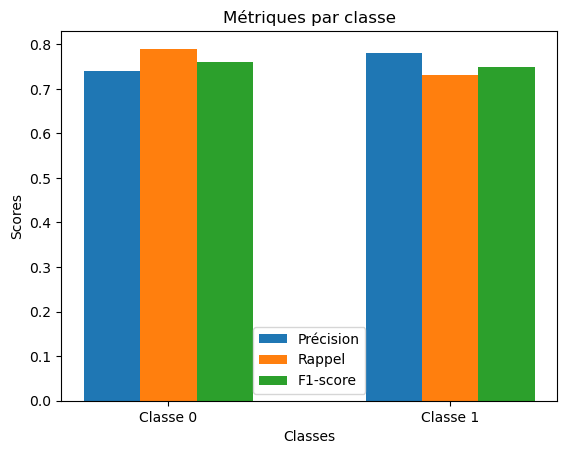

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Précision, Rappel, F1-score pour chaque classe
precision = [0.74, 0.78]
recall = [0.79, 0.73]
f1_score = [0.76, 0.75]

# Classes
classes = ['Classe 0', 'Classe 1']

# Barres pour chaque métrique
bar_width = 0.2
index = np.arange(len(classes))

fig, ax = plt.subplots()

bar1 = ax.bar(index, precision, bar_width, label='Précision')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Rappel')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-score')

# Ajouter les labels, la légende, et le titre
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Métriques par classe')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

# Afficher le graphique
plt.show()
